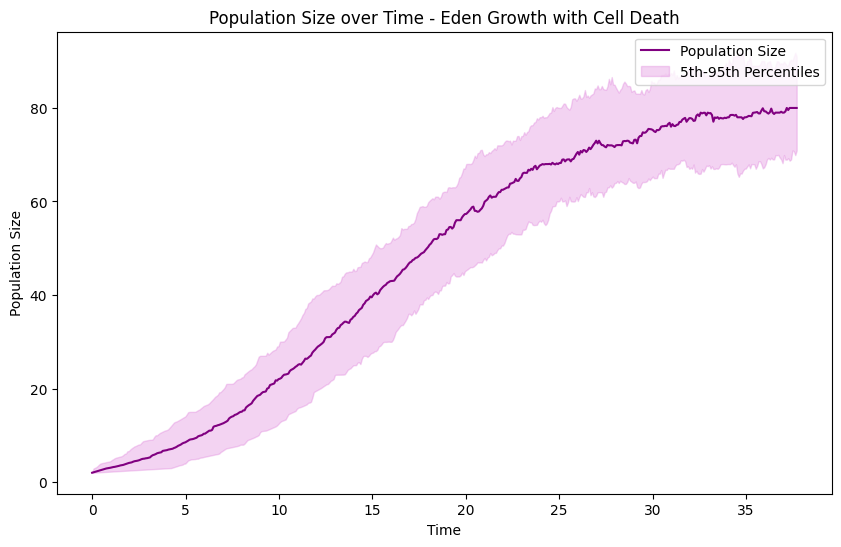

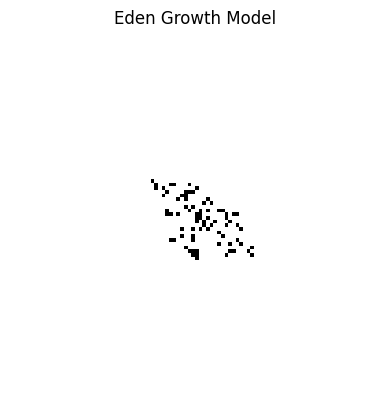

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_grid(size):
    grid = np.zeros((size, size), dtype=int)
    center = size // 2
    grid[center, center] = 1  # Start with a single occupied cell in the center
    border = set(get_moore_neighborhood(center, center, size))
    return grid, border

def get_moore_neighborhood(x, y, size):
    neighbors = [(i, j) for i in range(x-1, x+2) for j in range(y-1, y+2) if (0 <= i < size and 0 <= j < size)]
    neighbors.remove((x, y))
    return neighbors

def grow_cluster(grid, border, iterations, growth_rate, death_prob=0.01):
    size = grid.shape[0]
    population_size = []
    time_points = [0]  # Start with time zero
    
    for _ in range(iterations):
        if not border:
            break
        
        # Exponential time progression
        next_event_time = np.random.exponential(1 / (growth_rate * len(border)))
        time_points.append(time_points[-1] + next_event_time)
        
        new_site = list(border)[np.random.randint(len(border))]
        grid[new_site] = 1
        population_size.append(np.sum(grid))
        border.remove(new_site)
        
        for nx, ny in get_moore_neighborhood(*new_site, size):
            if grid[nx, ny] == 0:
                border.add((nx, ny))
        
        # Handle cell death
        death_sites = [(x, y) for x in range(size) for y in range(size) if grid[x, y] == 1 and np.random.rand() < death_prob]
        for ds in death_sites:
            grid[ds] = 0
            border.discard(ds)  # Remove dead cell from border if it was a border cell
        
        # Update border after cell death
        for x, y in death_sites:
            for nx, ny in get_moore_neighborhood(x, y, size):
                if grid[nx, ny] == 1:
                    border.add((nx, ny))
                elif (nx, ny) in border:
                    if all(grid[nxx, nyy] == 0 for nxx, nyy in get_moore_neighborhood(nx, ny, size)):
                        border.discard((nx, ny))
    
    return grid, population_size, time_points[:-1]  # make time_points and population_size the same length

def plot_grid(grid):
    plt.imshow(grid, cmap='Greys', interpolation='nearest')
    plt.title('Eden Growth Model')
    plt.axis('off')
    plt.show()

# Parameters
grid_size = 100
iterations = 500
growth_rate = 0.1
death_prob = 0.01
num_simulations = 100

# Run multiple simulations
all_population_sizes = []
all_time_points = []

for _ in range(num_simulations):
    grid, population_size, time_points = grow_cluster(*initialize_grid(grid_size), iterations, growth_rate, death_prob)
    all_population_sizes.append(np.interp(np.linspace(0, max(time_points), iterations), time_points, population_size))
    all_time_points.append(np.linspace(0, max(time_points), iterations))

all_population_sizes = np.array(all_population_sizes)
time_points = np.mean(all_time_points, axis=0)

# Calculate quantiles
quantiles_1 = np.percentile(all_population_sizes, 5, axis=0)
quantiles_2 = np.percentile(all_population_sizes, 95, axis=0)
median_population_size = np.median(all_population_sizes, axis=0)

# Plot population size over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, median_population_size, label='Population Size', color='purple')
plt.fill_between(time_points, quantiles_1, quantiles_2, color='orchid', alpha=0.3, label='5th-95th Percentiles')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Population Size over Time - Eden Growth with Cell Death')
plt.legend()
plt.show()

# Plot final grid 
plot_grid(grid)
